# Intro

Ok. As we're warming up to the project, today's exercises is going to ask you to create our own micro-project. It'll be highly structured and hosted on the web-page you created last time. Before we can start on that there's a bit of reading first. 

Thus, today's lecture has two parts:

* More reading on Narrative Data Visualization.
* Creating a micro project based on our work in the class so far.

So let's get started 😀

## Part 1: More on narrative data viz

*Reading*. More on Narrative Visualization. Edward Segel and Jeffrey Heer. [Narrative Visualization: Telling Stories with Data](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf), section 4-6.

> *Exercise*: Questions to the text
> 
> * What's the point of Figure 7?
> * Use Figure 7 to find the most common design choice within each category for the Visual narrative and Narrative structure (the categories within visual narrative are 'visual structuring', 'highlighting', etc).
> * Check out Figure 8 and section 4.3. What is your favorite genre of narrative visualization? Why? What is your least favorite genre? Why?

## Part 2: A short data story / micro-project

> *Exercise*: Create a short data-story based on the work we've done in class so far. (This exercise is a kind of "micro version" of what we'll be doing in the final project). Follow the directions in the bulleted list below when you create your data-story.

* **Find your own story to tell in the work on analyzing the SF Crime Data that we've done so far** (Week 1 - Week 6). The idea is to choose an insight about crime in SF (perhaps how something changed over the years) and communicate that insight to a general audience reader.
* The web-page should be hosted on your GitHub Pages site (Week 7).
* The format must be the classic *Magazine Genre* presented on a single web-page (see the Segel \& Heer paper for details).
* The story should have a brief introduction to the dataset so new readers from outside the class can understand what's going on.
* Your story should include three visualizations. Not more than three, not less than three (but multi-panel figures are OK). The figures should be one of each of the following types
  - One time-series / bar chart (it's OK to use the "fancy" plot-typs like calendar plots or polar bar-charts from Week 2, Part 4).
  - One map (use techniques from Week 3 and 4)
  - One interactive visualization in Bokeh (Week 6)
* **At a minimum, the Bokeh visualization should contain different data** than the exercise we did for Week 6 (it's a plus if it's a new type of viz altogether). 
* The two other visualization may be repetitions of figures created during the previous lectures, or they may be new.
* Make the figures nice. Specifically:
  - Aim to make the figures visually consistent (color, fonts, etc)
  - Follow the recommendations from my video on nice figures (Week 2, part 3)
* In terms of the amount of text, I envision something like 500-1500 words (including figure captions). <font color="gray">Try to write in your own words - the LLMs have a tendency to write a lot of text and not be so precise. So if the writing is all elegantly written but empty prose, we will be critical. It is OK, however, to have the LLM help you get the grammer, etc. right.</font>
* It is a plus if you can back up some of your findings with external sources, such as news stories from the area, looking up which building is located at some set of `lat,lon` coordinates, or similar. (So when you see something happening at some time/place in the data, see if you can understand it more deeply by investigating outside the dataset.) Use real references at the end of the text to organize your links to the outside world.

In [2]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
import json
import plotly.express as px
import plotly.graph_objects as go
import calendar

### Data loading

In [3]:
path = r"C:\Users\micha\OneDrive\Pulpit\DTU\S4\02806_Social\week1\Police_Department_Incident_Reports__Historical_2003_to_May_2018_20240129.csv"
data = pd.read_csv(path)
data['Date'] = pd.to_datetime(data['Date'])
data = data[~(data['Date'] > '2017-12-31')]

### DATA source
### https://www.cjcj.org/news/blog/san-franciscos-crime-wave-is-just-one-crime

### Explore vehicle theft data

In [14]:
grouped_data = data.groupby(['Category']).size().reset_index(name='crime_count')
sorted_data = grouped_data.sort_values('crime_count', ascending=False)

vehicle_data = data[data['Category'] == 'VEHICLE THEFT']
vehicle_data['Year'] = (pd.to_datetime(vehicle_data['Date'])).dt.year

print(vehicle_data[['Category', 'Descript']][:5])

         Category                               Descript
1   VEHICLE THEFT                      STOLEN AUTOMOBILE
2   VEHICLE THEFT                      STOLEN AUTOMOBILE
7   VEHICLE THEFT           STOLEN AND RECOVERED VEHICLE
43  VEHICLE THEFT                      STOLEN AUTOMOBILE
83  VEHICLE THEFT  RECOVERED VEHICLE - STOLEN OUTSIDE SF


C:\Users\micha\AppData\Local\Temp\ipykernel_2860\3889771874.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vehicle_data['Year'] = (pd.to_datetime(vehicle_data['Date'])).dt.year


In [16]:
motorcycle_data = vehicle_data[vehicle_data['Descript'].str.contains('MOTOR')]
print(motorcycle_data['Descript'].unique())
print("Total number of Motor VEHICLE THEFT data: ", len(motorcycle_data))

['STOLEN MOTORCYCLE' 'VEHICLE, RECOVERED, MOTORCYCLE'
 'VEHICLE, RECOVERED, CAMPER-HOUSE CAR-MOTOR HOME']
Total number of Motor VEHICLE THEFT data:  7350


In [17]:
year_motorcycle_data = motorcycle_data.groupby(['Year']).size().reset_index(name='crime_count')
print(year_motorcycle_data)

    Year  crime_count
0   2003          762
1   2004          740
2   2005          696
3   2006          341
4   2007          318
5   2008          289
6   2009          290
7   2010          296
8   2011          258
9   2012          341
10  2013          410
11  2014          548
12  2015          785
13  2016          674
14  2017          602


### Vehicle map data

In [33]:
with urlopen('https://raw.githubusercontent.com/suneman/socialdata2022/main/files/sfpd.geojson') as response:
    counties = json.load(response)

vehicle_grouped_data = motorcycle_data.groupby(['PdDistrict']).size().reset_index(name='crime_count')
vehicle_max_val = max(vehicle_grouped_data['crime_count'])
vehicle_min_val = min(vehicle_grouped_data['crime_count'])
print(f"Max value: {vehicle_max_val}, min value: {vehicle_min_val}")

Max value: 1220, min value: 97


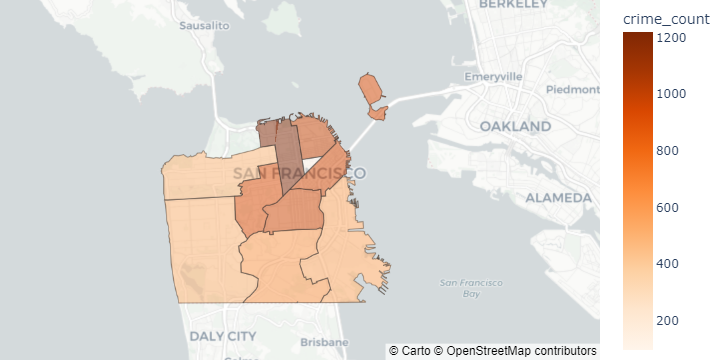

In [35]:
fig = px.choropleth_mapbox(vehicle_grouped_data, geojson=counties, locations='PdDistrict', color='crime_count',
                           color_continuous_scale="Oranges",
                           range_color=(vehicle_min_val, vehicle_min_val),
                           mapbox_style="carto-positron",
                           zoom=10, center = {"lat": 37.7749, "lon": -122.4194},
                           opacity=0.5
                          )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Explore break into cars data

In [25]:
# according to san fran. laws breaking into a vehicle and theft is considered a burglary 
# lets explore that data
burglary_data = data[data['Category'] == 'BURGLARY']
burglary_data['Year'] = (pd.to_datetime(burglary_data['Date'])).dt.year
burglary_data = burglary_data[burglary_data['Descript'].str.contains('VEH')]

print(burglary_data[['Category', 'Descript']][:5])
print(burglary_data['Descript'].unique())
print("Total number of brek ins into cars data: ", len(burglary_data))

      Category                               Descript
115   BURGLARY        BURGLARY, VEHICLE (ARREST MADE)
3357  BURGLARY        BURGLARY, VEHICLE (ARREST MADE)
5895  BURGLARY        BURGLARY, VEHICLE (ARREST MADE)
6026  BURGLARY        BURGLARY, VEHICLE (ARREST MADE)
6253  BURGLARY  BURGLARY, VEHICLE, ATT. (ARREST MADE)
['BURGLARY, VEHICLE (ARREST MADE)' 'BURGLARY, VEHICLE, ATT. (ARREST MADE)']
Total number of brek ins into cars data:  2378


C:\Users\micha\AppData\Local\Temp\ipykernel_2860\1932385359.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  burglary_data['Year'] = (pd.to_datetime(burglary_data['Date'])).dt.year


In [23]:
year_burglary_data = burglary_data.groupby(['Year']).size().reset_index(name='crime_count')
print(year_burglary_data)

   Year  crime_count
0  2009            2
1  2010          174
2  2011          195
3  2012          247
4  2013          345
5  2014          314
6  2015          383
7  2016          347
8  2017          371


### CAR break ins map data

In [36]:

burglary_grouped_data = burglary_data.groupby(['PdDistrict']).size().reset_index(name='crime_count')
burglary_max_val = max(burglary_grouped_data['crime_count'])
burglary_min_val = min(burglary_grouped_data['crime_count'])
print(f"Max value: {burglary_max_val}, min value: {burglary_min_val}")

Max value: 517, min value: 61


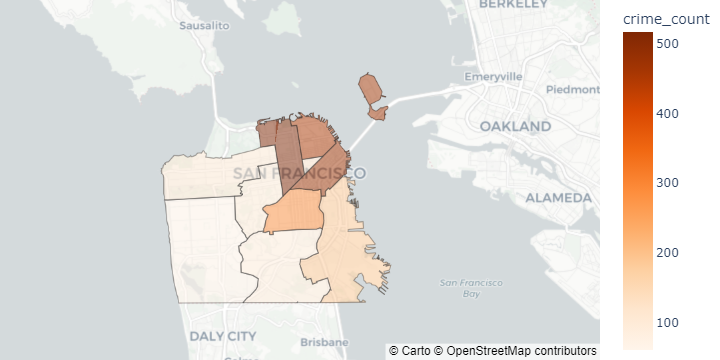

In [37]:
fig = px.choropleth_mapbox(burglary_grouped_data, geojson=counties, locations='PdDistrict', color='crime_count',
                           color_continuous_scale="Oranges",
                           range_color=(burglary_max_val, burglary_min_val),
                           mapbox_style="carto-positron",
                           zoom=10, center = {"lat": 37.7749, "lon": -122.4194},
                           opacity=0.5
                          )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Tourist atractions and areas in SF.
Pier 39, San Francisco, CA, USA 37.809326, -122.409981
# most popular areaas for tourists:
Financial District 37.7937° N, 122.3965° W
North Beach 37.7995° N, 122.4089° W
The Embarcadero 37.7993° N, 122.3977° W
Nob Hill 37.7910° N, 122.4174° W
The Mission 37.7636° N, 122.4174° W
Pacific Heights 37.7943° N, 122.4349° W


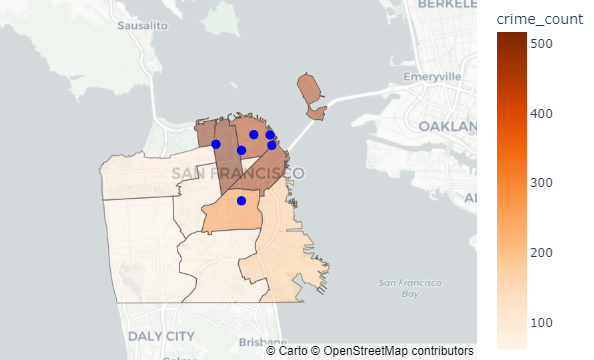

In [38]:
# Create DataFrame for points
points_data = pd.DataFrame({
    "Location": ["Financial District", "North Beach", "The Embarcadero", "Nob Hill", "The Mission", "Pacific Heights"],
    "Latitude": [37.7937, 37.7995, 37.7993, 37.7910, 37.7636, 37.7943],
    "Longitude": [-122.3965, -122.4089, -122.3977, -122.4174, -122.4174, -122.4349]
})

# Create choropleth map
fig = px.choropleth_mapbox(burglary_grouped_data, geojson=counties, locations='PdDistrict', color='crime_count',
                           color_continuous_scale="Oranges",
                           range_color=(burglary_max_val, burglary_min_val),
                           mapbox_style="carto-positron",
                           zoom=10, center = {"lat": 37.7749, "lon": -122.4194},
                           opacity=0.5
                          )

# Add points to the map
fig.add_scattermapbox(
    mode="markers",
    lon=points_data["Longitude"],
    lat=points_data["Latitude"],
    text=points_data["Location"],
    marker=dict(size=10, color="blue")
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()